In [2]:
#Dependencies
import re
import string
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Embedding, GlobalMaxPool1D, Bidirectional
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Activation
from keras.models import Sequential

In [2]:
warnings.filterwarnings('ignore')

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jharmse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### *Text Classification Workflow*

1. `Dataset Preparation`: loading a dataset and performing basic pre-processing and then splitted into train and validation data

2. `Feature Engineering`: transformed raw data into flat features which can be used in a machine learning model

3. `Model Training`: A machine learning model is trained on a labelled dataset

4. `Performance and Accuracy`: improve the performance of text classifiers by looking at accuracy measures and hyper parameter tuning.

> See the data import and preprocessing steps in detail below:

#### Feature Engineering

`Count Vector` is a matrix of term frequencies in which every row represents a document, every column represents a term in the document 

## TF-IDF - Akshi

> TF-IDF, which stands for term frequency — inverse document frequency, is a way to measure relevance of a term in a given document and is widely used in information summarization and topic modeling

The idea behind TFIDF is that if a word appears frequently in a document (text), we should increase it's relevance as it might be more relevant or describes the text better than words that appear fewer times. **TERM FREQUENCY**

Also, at the same time, if a word appears too many times in a document and also in other documents it means that its generally a frequent work and this makes it less relevant to that the document **INVERSE TERM FREQUENCY**

The *TfidfVectorizer* in python's Sklean converts a collection of document in to a matrix of documents and term frequencies

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names()) , print(X.shape)
X.toarray()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
(4, 9)


array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

> *TF-IDF* is used by search engines to better understand content which is undervalued and is utilized for serach engine optimization and text summarization

>  *TF-IDF* is also useful in filtering out stop words based on the term frequencies which may not be obvious using the NLP libraries
 

## Logistic Regression - Akshi

### Load the Data
The data can be found [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)

In [5]:
train = pd.read_csv('../additional/data/train.csv')
test = pd.read_csv('../additional/data/test.csv')
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

text_train = train['comment_text']
text_test = test['comment_text']
target_train = train[classes]

del train
del test

### Text processing

Some text processing techinques are used here to get our TF-IDF vectors.
- tokenization
- lower case
- remove stop words


In [7]:
def tokenize(s): 
    '''A simple tokenizer'''
    re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
    return re_tok.sub(r' ', s).split()

tfidf = TfidfVectorizer(tokenizer=tokenize, max_features=10000, 
                        stop_words='english', lowercase=True,
                        encoding='unicode', use_idf=1, 
                        smooth_idf=1, sublinear_tf=1)

tfidf.fit(text_train)
features_train = tfidf.transform(text_train) 
features_test = tfidf.transform(text_test) 

In [8]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    predictions = classifier.predict(feature_vector_valid)

    return metrics.accuracy_score(predictions, valid_y)

In [ ]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print "Logistic Regression, Count Vectors: ", accuracy


## Naive Bayes 

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. Commonly used for text classification. A detailed explanation about how it works can be found [here](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes)

![nb](../additional/img/naive_bayes_icon.png)

**Types of Naive Bayes Classifier:**
- **Multinomial Naive Bayes**: mostly used for document classification problem. The features/predictors used by the classifier are the frequency of the words present in the document.

- **Bernoulli Naive Bayes**: This is similar to the multinomial naive bayes but the predictors are boolean variables. 

- **Gaussian Naive Bayes**: predictors are continuous and assume to follow a Gaussian distribution.

This is a decent classifier with fast computation. However, its probailities prediction are not accurate because of the naive assumption.

Here below is a example of Multinomial Naive Bayes with tf-idf vectors. (Though data are typically represented as word vector counts (`CountVectorizer`), tf-idf vectors are also known to work well in practice)
 

In [73]:
def NaiveBayes_train():
    """This will train a NaiveBayes claassifier on all different lables and return the CV scores """
    scores = dict()

    for clss in classes:
        print(f'Fitting {clss}')
        nb = MultinomialNB()
        score = cross_val_score(nb, features_train, target_train[clss])
        scores[clss] = score
        print(f'Average CV score : {score.mean()}')
    
    return scores    

scores = NaiveBayes_train()

Fitting toxic
Average CV score : 0.9491887601658471
Fitting severe_toxic
Average CV score : 0.9902864585406871
Fitting obscene
Average CV score : 0.9713356422000471
Fitting threat
Average CV score : 0.9969606008850559
Fitting insult
Average CV score : 0.9672434233770661
Fitting identity_hate
Average CV score : 0.9912640774336109


## Word2vec 

### Intuition

If two different words have very similar “contexts” (that is, what words are likely to appear around them), then these two words are similar. 

And what does it mean for two words to have similar contexts? I think you could expect that synonyms like “intelligent” and “smart” would have very similar contexts. Or that words that are related, like “pretty” and “beautiful”, would probably have similar contexts as well.

This can also handle stemming for you – the network will likely learn similar word vectors for the words “ant” and “ants” because these should have similar contexts.

Putting back into the context of neural network. The word vectors of similar words will be similar. 

### Training

To get the word vectors, we’ll train the neural network by feeding it word pairs found in our training documents. We would take these word pairs from the sentence “The quick brown fox jumps over the lazy dog.” 

Here we have a window size of 2, so for each input word (in blue box), we'll have four output words (in white box).

<img src="../additional/img/input-output.png" style="width: 600px;"/>

There are two models for training word vectors
- Continuous bag-of-words (CBOW)
- Skip-gram


<img src="../additional/img/word2vec.png" style="width: 600px;"/>

### More details

Both input and output vector are one-hot encoding vectors representing the input and output words.

The hidden layer size correspond to the dimensions of the word vectors. The weight matrix is our word vectors.

<img src="../additional/img/skip_gram.png" style="width: 800px;"/>

#### Some techniques to speed things up
- **Subsampling frequent words** to decrease the number of training examples.
- **Negative sampling** (to update only a small percentage of the model’s weights.)

### Let's try it out!
To train your own word vectors in Python, we will use the Gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec).

First, we'll need to transfer the text into a list of list of words.

In [53]:
corpus = [tokenize(sentence) for sentence in text_train]

print(corpus[:3])

[['Explanation', 'Why', 'the', 'edits', 'made', 'under', 'my', 'username', 'Hardcore', 'Metallica', 'Fan', 'were', 'reverted', 'They', 'weren', 't', 'vandalisms', 'just', 'closure', 'on', 'some', 'GAs', 'after', 'I', 'voted', 'at', 'New', 'York', 'Dolls', 'FAC', 'And', 'please', 'don', 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'I', 'm', 'retired', 'now', '89', '205', '38', '27'], ['D', 'aww', 'He', 'matches', 'this', 'background', 'colour', 'I', 'm', 'seemingly', 'stuck', 'with', 'Thanks', 'talk', '21', '51', 'January', '11', '2016', 'UTC'], ['Hey', 'man', 'I', 'm', 'really', 'not', 'trying', 'to', 'edit', 'war', 'It', 's', 'just', 'that', 'this', 'guy', 'is', 'constantly', 'removing', 'relevant', 'information', 'and', 'talking', 'to', 'me', 'through', 'edits', 'instead', 'of', 'my', 'talk', 'page', 'He', 'seems', 'to', 'care', 'more', 'about', 'the', 'formatting', 'than', 'the', 'actual', 'info']]


Then we will train it with `Word2Vec`. We specify the hyper-parameters as follow.

In [62]:
num_features = 150   # Word vector dimensionality                      
min_word_count = 5   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 3         # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words
neg_sampling = 5      # number of negative samples
algo = 1              # skip-gram

model = Word2Vec(corpus, size=num_features, window=context, min_count=min_word_count,
                 workers=num_workers, negative=neg_sampling, sg=algo, sample=downsampling)

Ta da! We have finished the training of our Word2Vec, let's test it with some examples

Below we find the most similar words for a given word.

In [63]:
some_words = ['pervert', 'terrible', 'idiot', "America", "dumb", "3"]

for word in some_words:
    print(f"Similar words for {word}")
    for w in model.wv.most_similar(word, topn=5):
        print(w)
    print('='*30)

Similar words for pervert
('slut', 0.8627091646194458)
('dyke', 0.8565641045570374)
('crybaby', 0.8534049391746521)
('pansy', 0.8474336266517639)
('pimp', 0.8472767472267151)
Similar words for terrible
('horrible', 0.7133010625839233)
('pitiful', 0.6998237371444702)
('horrendous', 0.6992303133010864)
('bad', 0.6866238117218018)
('brilliant', 0.6837822794914246)
Similar words for idiot
('imbecile', 0.7698673009872437)
('asshole', 0.7644912600517273)
('coward', 0.7408623695373535)
('prick', 0.7340831756591797)
('dumbass', 0.7308950424194336)
Similar words for America
('North', 0.67038893699646)
('Korea', 0.6635521650314331)
('Japan', 0.6539624929428101)
('Mongolia', 0.6471944451332092)
('Italy', 0.6443969011306763)
Similar words for dumb
('stupid', 0.7564776539802551)
('fucks', 0.7212205529212952)
('goddamn', 0.7163424491882324)
('dumbass', 0.7152076959609985)
('shithead', 0.7121809124946594)
Similar words for 3
('4', 0.898752748966217)
('2', 0.8645785450935364)
('6', 0.8347511291503906)

Here is another way of doing it.

In [64]:
model.wv.most_similar(positive=["man", "woman"], 
                      negative=['gentleman'], topn=5)

[('devil', 0.5384185314178467),
 ('lady', 0.5288782715797424),
 ('cow', 0.5227537155151367),
 ('eyed', 0.5214235782623291),
 ('demon', 0.5192208886146545)]

Let's visualize it with t-SNE. 

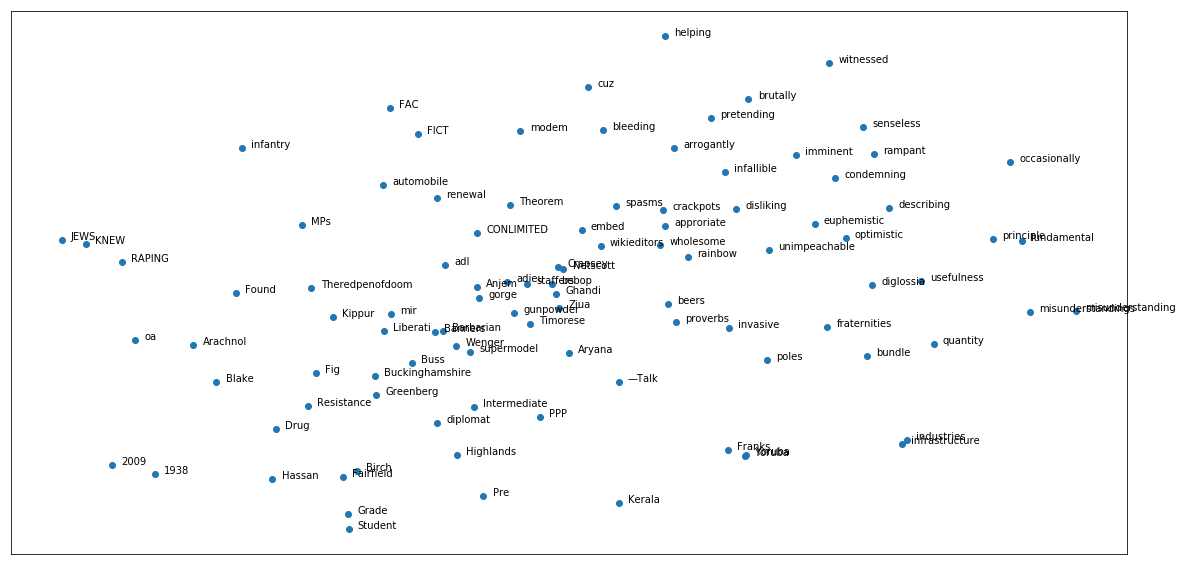

In [68]:
# filter out a subset of words for visualization
vocab = len(model.wv.vocab)
n = 100
index = np.random.randint(low=0, high=vocab, size=n)

wordvec = model[model.wv.vocab][index]
words = np.array([*model.wv.vocab])[index]

# initialize the t-SNE
tsne = TSNE(n_components=2)
word_transformed = tsne.fit_transform(wordvec)

x_axis = word_transformed[:, 0]
y_axis = word_transformed[:, 1]

# plot!
plt.figure(figsize=(20,10))
plt.scatter(x_axis, y_axis)
plt.xticks([])
plt.yticks([])
for i, txt in enumerate(words):
    plt.annotate(txt, (x_axis[i]+0.07, y_axis[i]))
plt.show()

## Multilayer Perceptron - Matt

### Data Import

For this project, we are using Kaggle's toxic comment datasets. The data, and an overview of the data, can be found [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data).

There are two files worth taking note of:

* `train.csv`
* `test.csv`

We will *train* our models on the `train.csv` data. To ensure that our model isn't memorising the training data (a.k.a. overfitting), we will *test* our model on the independent `test.csv` data.

`test.csv` has the same format as `train.csv`, but contains never-seen-before comment. Testing our model on this dataset, will give us an indication of whether our model works in a real-world application (will it be able to flag or delete new, unseen toxic comments?).

In [3]:
train = pd.read_csv('../additional/data/train.csv')
test_X = pd.read_csv('../additional/data/test.csv')
test_labels = pd.read_csv('../additional/data/test_labels.csv')

print("Training data examples:")
display(train.head())
print("Test input examples:")
display(test_X.head())
print("Test expected output examples:")
display(test_labels.head())

Training data examples:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Test input examples:


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Test expected output examples:


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


The test data contains a bunch of `-1` values. These comments cannot be considered as toxic or non-toxic and should be omitted from scoring (see Kaggle link).

In [4]:
# cleaner ways of doing this, but whatevs
remove_rows = test_labels.toxic != -1
test_labels = test_labels[remove_rows]
test_X = test_X[remove_rows]

display(test_X.head())
test_labels.head()

,id,comment_text
5,0001ea8717f6de06,Thank you for understanding. I think very high...
7,000247e83dcc1211,:Dear god this site is horrible.
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0


For our needs, we are only interested in wether a comment is toxic or not. We aren't interested in the type of toxicity. Let's change the comment labels to a binary label.

In [5]:
# train data
train_y = train.iloc[:, 2:] != np.zeros((len(train), 6))
train_y = train_y.any(axis=1)

# test data
test_y = test_labels.iloc[:, 1:] != np.zeros((len(test_labels), 6))
test_y = test_y.any(axis=1)

print('Training data Binary Response Variable')
print(train_y.head())
print('\nTest data Binary Response Variable')
print(test_y.head())

Training data Binary Response Variable
0    False
1    False
2    False
3    False
4    False
dtype: bool

Test data Binary Response Variable
5     False
7     False
11    False
13    False
14    False
dtype: bool


In this case, `True` represents a *toxic* comment. `False` represents *non-toxic*. However, for a mathematical model to work, we need numbers. We will convert `True` to `1` and `False` to `0`.

In [6]:
train_y = train_y.astype(float)
test_y = test_y.astype(float)
print('Training Data Response Variable')
print(train_y.head())
print('\nTest Data Response Variable')
print(test_y.head())

Training Data Response Variable
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

Test Data Response Variable
5     0.0
7     0.0
11    0.0
13    0.0
14    0.0
dtype: float64


The toxic comment datasets are quite big.

In [7]:
print(f'Number of training samples: {len(train_y)}')
print(f'Number of test samples: {len(test_y)}')

Number of training samples: 159571
Number of test samples: 63978


Neural networks are generally quite complex, which means that training can take very long. For this reason, let's reduce the number of examples we train on. This will most likely reduce our accuracy, but will increase the training time.

To prevent training on comments that are mostly non-toxic (a non-toxic comment is more likely to occur than a toxic comment), we can reduce the training data by omitting more non-toxic comments. In the example below we try to end up with an equal amount of non-toxic and toxic comments in our training data. This will also prevent the model from having a higher probability of predicting a comment as non-toxic, simply becuase it's a more common occurance.

In [8]:
train_toxic = train_y[train_y == 1.0]
train_non_toxic = train_y[train_y == 0.0]
train_non_toxic = train_non_toxic[:len(train_toxic)]

rows_keep = list(train_toxic.index)
rows_keep = rows_keep + list(train_non_toxic)
rows_keep.sort()

train_y = train_y.iloc[rows_keep]
train = train.iloc[rows_keep]

#shuffle the data to improve results
train, train_y = shuffle(train, train_y, random_state=123)

In [9]:
print(f'Number of training samples: {len(train_y)}')

Number of training samples: 32450


### Data Preprocessing

In our last workshop we spoke about multiple text preprocessing techniques. For reasons already discussed, these preprocessing techniques might help the accuracy of your model a lot.

Below we are only applying the following preprocessing techniques:

* make comments lowercase
* split comments into individual words (1-gram).
* remove stopwords

Feel free to apply more preprocessing techniques here before training your model.

In [10]:
def preproc_line(line):
    text = re.sub(r"[^a-zA-Z0-9]", " ", line.lower())
    words = text.split()
    words = [w for w in words if w not in stopwords.words('english')]
  
    return words

In [13]:
# training data
X_train_pro = []

for line in train['comment_text']:
    X_train_pro.append(preproc_line(line))
    
# test data
X_test_pro = []

for line in test_X['comment_text']:
    X_test_pro.append(preproc_line(line))

In [14]:
X_train_pro[0]

['explanation',
 'edits',
 'made',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'reverted',
 'vandalisms',
 'closure',
 'gas',
 'voted',
 'new',
 'york',
 'dolls',
 'fac',
 'please',
 'remove',
 'template',
 'talk',
 'page',
 'since',
 'retired',
 '89',
 '205',
 '38',
 '27']

### Word Vectorizing

Next we need to present our comments as numerical vectors.

You can use more complex techniques, such as `word2vec`, but for this example we simply consider the 20000 most common words and represent each comment as a vector in terms of these common words.

In [15]:
# number of most common words to use
max_features = 20000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_pro)) # we only look at words occurring in training data

X_train_tokenized = tokenizer.texts_to_sequences(X_train_pro)
X_test_tokenized = tokenizer.texts_to_sequences(X_test_pro)

In [16]:
X_train_tokenized[0]

[14,
 4,
 5,
 15,
 21,
 23,
 9,
 10,
 24,
 26,
 20,
 22,
 6,
 12,
 27,
 25,
 3,
 8,
 11,
 2,
 1,
 7,
 19,
 16,
 18,
 17,
 13]

As with any machine learning model, we need to have a fixed number of features. Since comments can contain a varying number of words, we need to limit the number of words that can occur in a comment being classified. For our model we will allow a maximum of 200 words per comment that is fed into our model. Any comment containing fewer words, will be padded with a bunch of zeros.

In [17]:
max_len = 200
X_train_pad = pad_sequences(X_train_tokenized, maxlen=max_len)
X_test_pad = pad_sequences(X_test_tokenized, maxlen=max_len)

In [18]:
X_train_pad[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 14,  4,  5, 15, 21, 23,  9, 10, 24, 26, 20, 22,  6, 12,
       27, 25,  3,  8, 11,  2,  1,  7, 19, 16, 18, 17, 13], dtype=int32)

### Creating the Model

A multilayer perceptron is just another word for a normal neural network. For a neural network to be considered a deep neural network, it should have at least 2 hidden layers.

![](../additional/img/ANN.jpg)

In our case, our input layer should have a size of 200, since our comments are represented as word vectors, each having a size of 200.

Both our hidden layers have a size of 32. This is arbitrary and can be optimised.

The `relu` activation functions change linear outputs from the neurons to non-linear outputs. This ensures that we aren't simply training a complicated linear regression model.

THe last layer has a size of 1 and a `sigmoid` activation function. This layer allows the output the model to be a single value per sample that has a value between 0 and 1. This value can be seen as the probability of a comment being toxic (close to 1.0 means it is more likely that it is toxic).

![](../additional/img/activations.png)

The `Dropout` lines below essentially mean that we *turn off* a cerain fraction of neurons (50% in this case) and see if the model gives similar performance. If this is the case, we know that we can deactivate the neurons which will result in a simpler model.

If you want a clearer understanding of how neural networks work, play around with them [here](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.44195&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

In [57]:
K.clear_session()

# size of input layer
input_dim = len(X_train_pad[0])

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=input_dim))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', input_dim=input_dim))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                6432      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 7,521
Trainable params: 7,521
Non-trainable params: 0
_________________________________________________________________
None


We need to specify how our model is trained. Below follows standard binary model training parameters. You can find more details about these [here](https://keras.io/getting-started/sequential-model-guide/#training).

In short, we are using [RMSProp](https://keras.io/optimizers/#rmsprop) to find the best neural network weights that minimizes our loss, [Binary Cross Entropy](https://keras.io/losses/). The metric we use for our model is [Accuracy](https://keras.io/metrics/).

In [58]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
             metrics=['accuracy'])

Now we can train our model.

We feed in batches of data during training. In this example, our batch size is 32, which means that 32 training data comments are being fed into the mdoel during each iteration. During an iteration, the model weights are updated in an attempt to reduce our loss. This is done, using a technique called backpropagation.

Epochs refer to the number of times the full training dataset gets fed into the model during training. Having epochs=4, means our model sees each training example 4 times during the training process. Be careful for setting the number of epopchs too high, becuase this can result in overfitting.

The validation split specifies that 10% of the data should be used as validation data, while 90% is used for training. This gives us an indication of whether the model is underfitting or overfitting at any stage during the training process.

In [59]:
model.fit(X_train_pad, train_y, epochs=1, batch_size=32, validation_split=0.1, shuffle=True)

Train on 29205 samples, validate on 3245 samples
Epoch 1/1
29205/29205 [==============================] - 2s 69us/step - loss: 1.6849 - acc: 0.8794 - val_loss: 0.7207 - val_acc: 0.9550


In [60]:
test_y = test_y.astype(int)

score = model.evaluate(X_test_pad, test_y, batch_size=32)
print(f'Test Accuracy: {score[1]}')

63978/63978 [==============================] - 1s 18us/step
Test Accuracy: 0.2087592609964332


## Bidirectional Long Short-Term Memory (LSTM) Network - Matt

A bidirecitonal LSTM is part of the neural network family. Its arcitechture is slightly more complex than the neural network above. The benefit of this complexity is that this neural network handles sequential data much better.

Since we are working with comments the sequence of words within each comment is adds a lot of value. In the model above, we didn't consider the position of each word in a comment. With an LSTM we can feed in each comment as a sequence of words, while mainting its position in the comment, and let the model decide which parts of the comment is worth taking note of. A **bidirecitional** LSTM reads in the words from front to back in the first hidden layer, and then back to front in the next layer. This gives the model more context of the sequential nature of each comment.

![](../additional/img/BRNN.png)

![](../additional/img/lstm_cell.png)

In [61]:
def create_network(input_dim, embed_size, units, layers, output_dim, prob=0.2):
    input_ = Input(name='input_', shape=(input_dim, ))
    embed = Embedding(input_dim, embed_size)(input_)

    def add_layer(input_layer, units, name):
        lstm = Bidirectional(LSTM(units, return_sequences=True, activation='relu',
                                 name=name))(input_layer)
        bn_layer = BatchNormalization()(lstm)
        return bn_layer

    for i in range(layers):
        if i == 0:
            last_layer = add_layer(embed, units, 'rnn0')
        else:
            last_layer = add_layer(last_layer, units, 'rnn'+str(i))

    x = Dropout(prob)(last_layer)
    x = GlobalMaxPool1D()(x)
    x = Dense(units, activation='relu')(x)
    x = Dropout(prob)(x)
    logits = Dense(output_dim, name='logits')(x)
    out = Activation('sigmoid', name='out')(logits)
    model = Model(inputs=input_, outputs=out)

    print(model.summary())

    return model

In [62]:
embed_size = 128
units = 32
layers = 2
batch_size = 32
epochs = 1

In [63]:
K.clear_session()
model = create_network(max_len, embed_size, units, layers, 1)
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ (InputLayer)          (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          25600     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 64)           41216     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 64)           256       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 64)           24832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 64)           256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 64)           0         
__________

In [64]:
model.fit(X_train_pad, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1, shuffle=True)

Train on 29205 samples, validate on 3245 samples
Epoch 1/1
29205/29205 [==============================] - 686s 23ms/step - loss: 0.1188 - acc: 0.9606 - val_loss: 0.6932 - val_acc: 0.4931


In [65]:
score = model.evaluate(X_test_pad, test_y, batch_size=32)
print(f'Test Accuracy: {score[1]}')

63978/63978 [==============================] - 448s 7ms/step
Test Accuracy: 0.9024195817274935


## Accuracy - Akshi

## AUC (ROC) - Akshi